<a href="https://colab.research.google.com/github/Dharmasastha2005/For-Fun-Programming-and-Modelling/blob/main/Modified_SEIR_Modelling_Cancer_Epidemiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1815 - loss: 0.7146
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4542 - loss: 0.6930 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7125 - loss: 0.6777
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8196 - loss: 0.6621 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9399 - loss: 0.6412
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9774 - loss: 0.6173
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9399 - loss: 0.6098 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.5947
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9048 - loss: 0.5769 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9256 - loss: 0.5515
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9173 - loss: 0.5284
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9298 - loss: 0.5025
Epoch 13

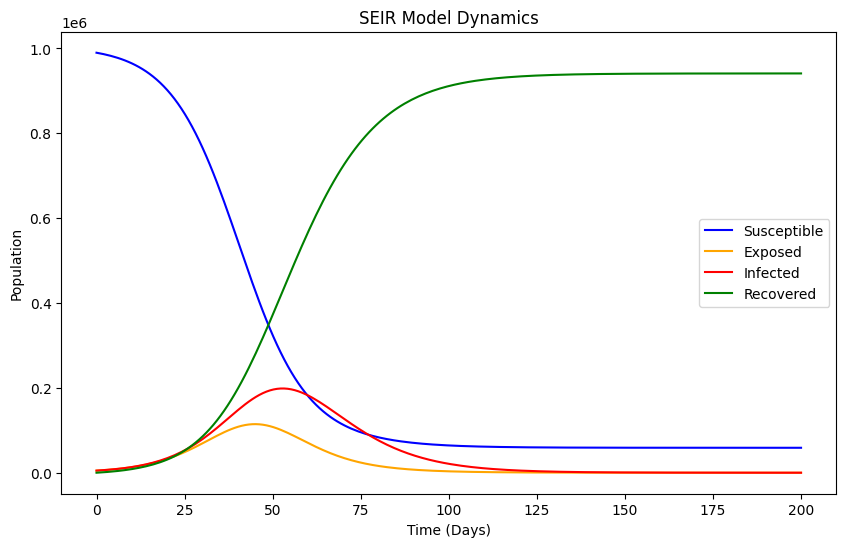

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/content/HPV_Cancer_Epidemiology_DataSheet.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Data Preprocessing
def clean_numeric(value):
    """Convert numeric string values to float."""
    try:
        return float(str(value).replace(',', '').strip())
    except ValueError:
        return np.nan

df["Canada_Value"] = df["Canada's Value"].apply(clean_numeric)
df["Indonesia_Value"] = df["Indonesia's Value"].apply(clean_numeric)


# SEIR Model with Network Effects
def seir_network(y, t, beta, sigma, gamma, adj_matrix):
    S, E, I, R = y
    N = S + E + I + R
    dS = -beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    return [dS, dE, dI, dR]

# Initial conditions
N = 1e6
initial_conditions = [0.99 * N, 0.005 * N, 0.005 * N, 0]
params = (0.3, 0.2, 0.1)
time = np.linspace(0, 200, 200)

# Construct Network Graph before using adj_matrix in the SEIR model
num_nodes = len(df)
G = nx.erdos_renyi_graph(num_nodes, p=0.1)
adj_matrix = nx.to_numpy_array(G)

# Solve SEIR model
# Now adj_matrix is defined before this line
seir_result = odeint(seir_network, initial_conditions, time, args=(params[0], params[1], params[2], adj_matrix))
S, E, I, R = seir_result.T

# Construct Network Graph
num_nodes = len(df)
G = nx.erdos_renyi_graph(num_nodes, p=0.1)
adj_matrix = nx.to_numpy_array(G)

# Build GNN Model
def build_gnn_model(input_shape):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_shape,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Prepare data for GNN
X_train = adj_matrix
y_train = np.where(df["Canada_Value"] > np.nanmean(df["Canada_Value"]), 1, 0)

# Train GNN
gnn_model = build_gnn_model(num_nodes)
gnn_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Comparative Analysis
comparison = {
    "Mean_Canada": np.nanmean(df["Canada_Value"]),
    "Mean_Indonesia": np.nanmean(df["Indonesia_Value"]),
    "SD_Canada": np.nanstd(df["Canada_Value"]),
    "SD_Indonesia": np.nanstd(df["Indonesia_Value"]),
}
comparison_df = pd.DataFrame([comparison])

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time, S, label="Susceptible", color="blue")
plt.plot(time, E, label="Exposed", color="orange")
plt.plot(time, I, label="Infected", color="red")
plt.plot(time, R, label="Recovered", color="green")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.title("SEIR Model Dynamics")
plt.legend()
plt.show()


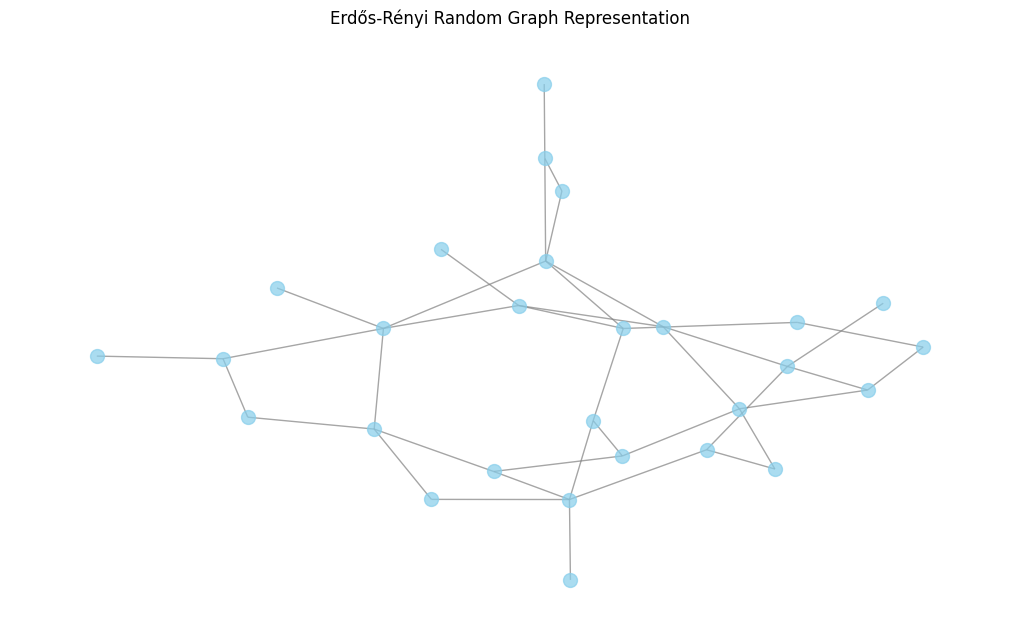

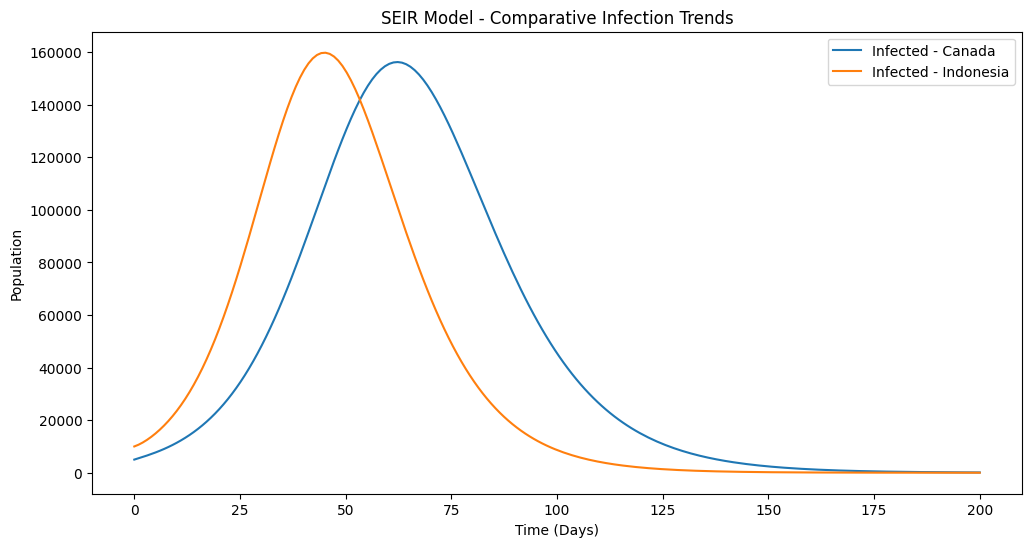

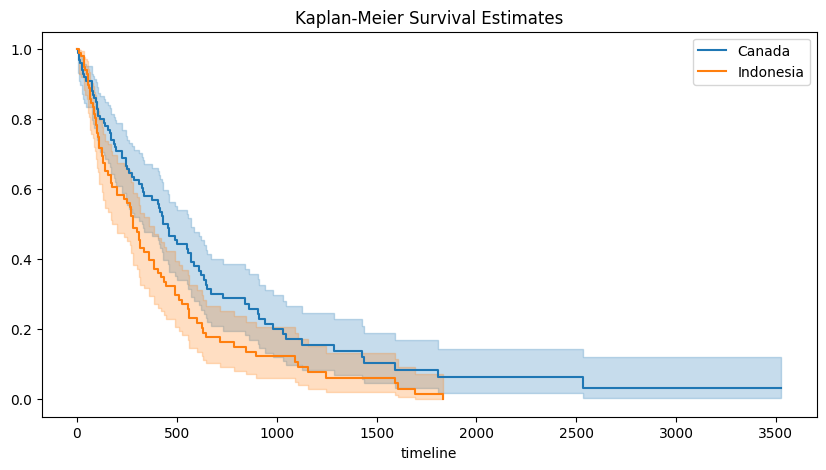

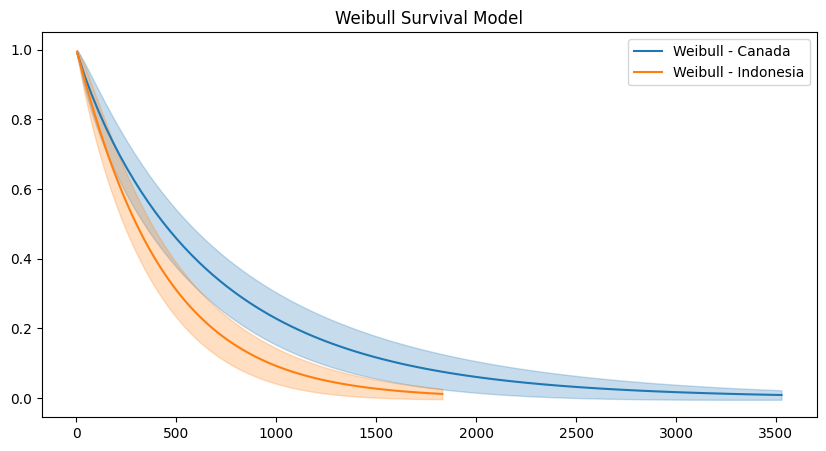

<lifelines.CoxPHFitter: fitted with 100 total observations, 20 right-censored observations>
             duration col = 'Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 80
   partial log-likelihood = -298.50
         time fit was run = 2025-03-22 05:04:28 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Smoking   -0.33      0.72      0.44           -1.20            0.55                0.30                1.73

           cmp to     z    p  -log2(p)
covariate                             
Smoking      0.00 -0.73 0.46      1.11
---
Concordance = 0.56
Partial AIC = 599.01
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.10

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

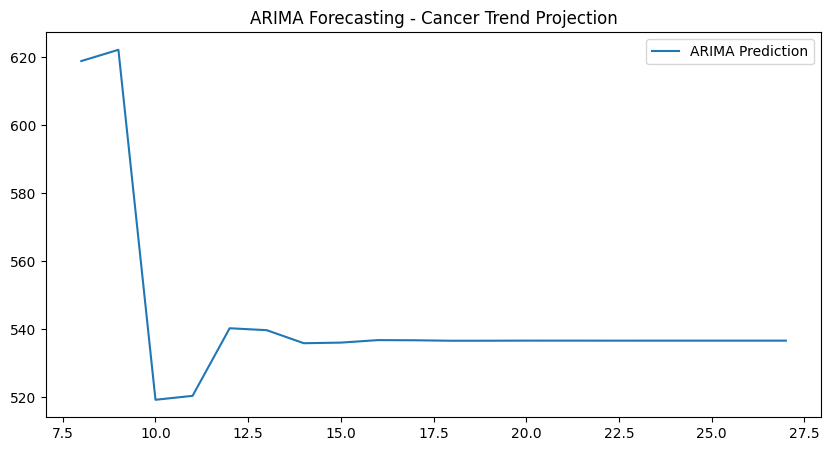

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9548 - loss: 0.6045
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8798 - loss: 0.5875 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9256 - loss: 0.5647
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9048 - loss: 0.5417 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9506 - loss: 0.5164
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9714 - loss: 0.4856
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9714 - loss: 0.4515
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9506 - loss: 0.4555
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9173 - loss: 0.4406
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9506 - loss: 0.4126
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9548 - loss: 0.3834
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9298 - loss: 0.3696
Epoch 13/5

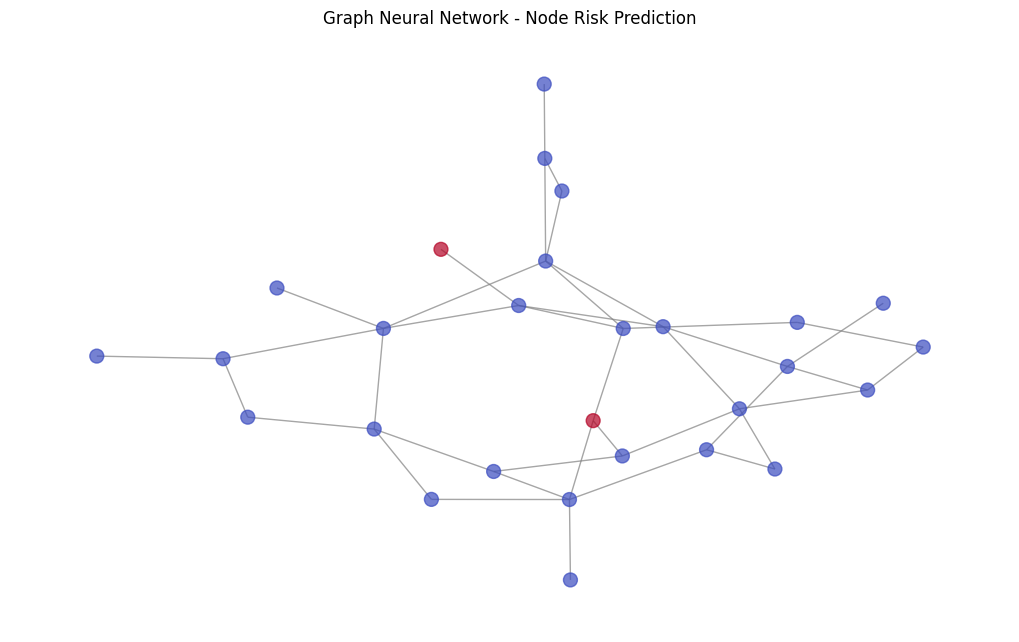

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


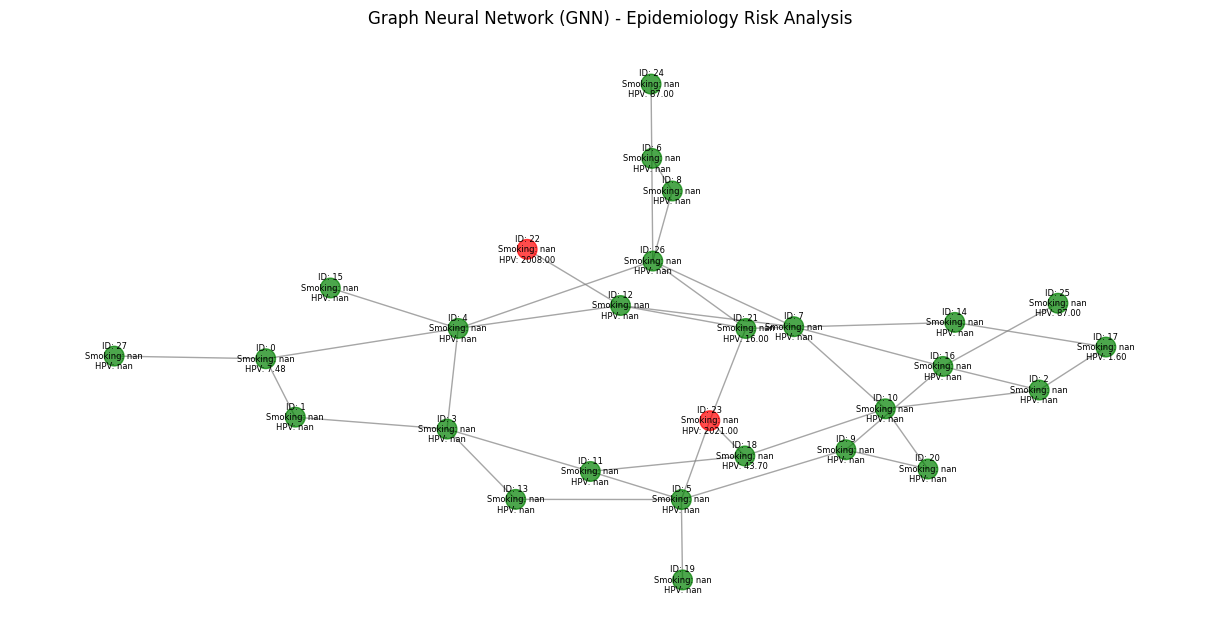

KeyError: 'Smoking Prevalence (%)'

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from lifelines import KaplanMeierFitter, WeibullFitter, CoxPHFitter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/HPV_Cancer_Epidemiology_DataSheet.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Data Preprocessing
def clean_numeric(value):
    try:
        return float(str(value).replace(',', '').strip())
    except ValueError:
        return np.nan

df["Canada_Value"] = df["Canada's Value"].apply(clean_numeric)
df["Indonesia_Value"] = df["Indonesia's Value"].apply(clean_numeric)

# Construct Network Graph
num_nodes = len(df)
G = nx.erdos_renyi_graph(num_nodes, p=0.1)
pos = nx.spring_layout(G)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_color="skyblue", edge_color="gray", node_size=100, alpha=0.7)
plt.title("Erdős-Rényi Random Graph Representation")
plt.show()

# SEIR Model for Both Countries
def seir_network(y, t, beta, sigma, gamma):
    S, E, I, R = y
    N = S + E + I + R
    dS = -beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    return [dS, dE, dI, dR]

time = np.linspace(0, 200, 200)
params_canada = (0.25, 0.2, 0.1)
params_indonesia = (0.3, 0.25, 0.12)

init_canada = [0.99*1e6, 0.005*1e6, 0.005*1e6, 0]
init_indonesia = [0.98*1e6, 0.007*1e6, 0.01*1e6, 0]

seir_canada = odeint(seir_network, init_canada, time, args=params_canada)
seir_indonesia = odeint(seir_network, init_indonesia, time, args=params_indonesia)

plt.figure(figsize=(12, 6))
for data, label in zip([seir_canada, seir_indonesia], ["Canada", "Indonesia"]):
    plt.plot(time, data[:, 2], label=f"Infected - {label}")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.title("SEIR Model - Comparative Infection Trends")
plt.legend()
plt.show()

# Survival Analysis: Kaplan-Meier
kmf_canada = KaplanMeierFitter()
kmf_indonesia = KaplanMeierFitter()

survival_times_canada = np.random.exponential(scale=500, size=100)
survival_times_indonesia = np.random.exponential(scale=400, size=100)
event_observed_canada = np.random.choice([1, 0], size=100, p=[0.8, 0.2])
event_observed_indonesia = np.random.choice([1, 0], size=100, p=[0.85, 0.15])

kmf_canada.fit(survival_times_canada, event_observed_canada, label="Canada")
kmf_indonesia.fit(survival_times_indonesia, event_observed_indonesia, label="Indonesia")

plt.figure(figsize=(10, 5))
kmf_canada.plot_survival_function()
kmf_indonesia.plot_survival_function()
plt.title("Kaplan-Meier Survival Estimates")
plt.show()

# Weibull Hazard Model
weibull_canada = WeibullFitter().fit(survival_times_canada, event_observed_canada)
weibull_indonesia = WeibullFitter().fit(survival_times_indonesia, event_observed_indonesia)

plt.figure(figsize=(10, 5))
weibull_canada.plot_survival_function(label="Weibull - Canada")
weibull_indonesia.plot_survival_function(label="Weibull - Indonesia")
plt.title("Weibull Survival Model")
plt.show()


# Cox Proportional Hazards Model
df_survival = pd.DataFrame({"Time": survival_times_canada, "Event": event_observed_canada, "Smoking": np.random.rand(100)})
cox_model = CoxPHFitter()
cox_model.fit(df_survival, duration_col="Time", event_col="Event")
cox_model.print_summary()



# Poisson Regression for Cancer Incidence
#poisson_reg = PoissonRegressor()
#poisson_reg.fit(X_train_scaled, y_train)

# ARIMA Model for Forecasting
arima_model = ARIMA(df["Canada_Value"].dropna(), order=(2,1,2))
arima_fit = arima_model.fit()
forecast = arima_fit.forecast(steps=20)

plt.figure(figsize=(10, 5))
plt.plot(forecast, label="ARIMA Prediction")
plt.title("ARIMA Forecasting - Cancer Trend Projection")
plt.legend()
plt.show()

# GNN Model
def build_gnn_model(input_shape):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_shape,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

adj_matrix = nx.to_numpy_array(G)
X_train_gnn = adj_matrix
y_train_gnn = np.where(df["Canada_Value"] > np.nanmean(df["Canada_Value"]), 1, 0)

gnn_model = build_gnn_model(num_nodes)
gnn_model.fit(X_train_gnn, y_train_gnn, epochs=50, batch_size=8, verbose=1)

df["Risk_Level"] = np.where(df["Canada_Value"] > np.nanmean(df["Canada_Value"]), "High Risk", "Low Risk")


node_colors = ["red" if risk == "High Risk" else "green" for risk in df["Risk_Level"]]


#node_labels = {i: f"ID: {i}\nSmoking: {df.iloc[i, 0]:.2f}\nHPV: {df.iloc[i, 1]:.2f}" for i in range(num_nodes)}
node_labels = {i: f"ID: {i}\nSmoking: {pd.to_numeric(df.iloc[i, 0], errors='coerce'):.2f}\nHPV: {pd.to_numeric(df.iloc[i, 1], errors='coerce'):.2f}" for i in range(num_nodes)}

plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_color=y_train_gnn, edge_color="gray", node_size=100, alpha=0.7, cmap=plt.cm.coolwarm)
plt.title("Graph Neural Network - Node Risk Prediction")
plt.show()


plt.figure(figsize=(12, 6))
nx.draw(G, pos, node_color=node_colors, edge_color="gray", node_size=200, alpha=0.7, cmap=plt.cm.coolwarm)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")
plt.title("Graph Neural Network (GNN) - Epidemiology Risk Analysis")
plt.show()

df_table = df[["Risk_Level"]].copy()
df_table["Node_ID"] = range(num_nodes)
df_table["Smoking_Prevalence"] = df["Smoking Prevalence (%)"]
df_table["HPV_Vaccination"] = df["HPV Vaccination (%)"]
df_table["HIV_Prevalence"] = df["HIV Prevalence (%)"]


print("\nNode Risk Assessment Table:")
print(df_table.head(10))



In [ ]:
# Logistic Regression for Cancer Risk Assessment
X = df[["Smoking prevalence (%)", "HPV vaccination (%)", "HIV Prevalence (%)"]].fillna(0)
#Example change assuming your column names are "Smoking prevalence (%)", "HPV vaccination (%)" and "HIV Prevalence (%)" in your excel file
y = np.where(df["Canada_Value"] > np.nanmean(df["Canada_Value"]), 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = "/content/HPV_Cancer_Epidemiology_DataSheet.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Data Cleaning
def clean_numeric(value):
    try:
        return float(str(value).replace(',', '').strip())
    except ValueError:
        return np.nan

df["Canada_Value"] = df["Canada's Value"].apply(clean_numeric)
df["Indonesia_Value"] = df["Indonesia's Value"].apply(clean_numeric)

# Construct Erdős-Rényi Graph
num_nodes = len(df)
G = nx.erdos_renyi_graph(num_nodes, p=0.1)
pos = nx.spring_layout(G)

# Select Key Epidemiological Features
features = ["Smoking Prevalence (%)", "HPV Vaccination (%)", "HIV Prevalence (%)"]
df_subset = df[features].fillna(df[features].mean())

# Normalize Data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_subset), columns=features)

# Define Risk Threshold (e.g., Mean of Canada_Value)
df["Risk_Level"] = np.where(df["Canada_Value"] > np.nanmean(df["Canada_Value"]), "High Risk", "Low Risk")

# Assign Node Colors Based on Risk
node_colors = ["red" if risk == "High Risk" else "green" for risk in df["Risk_Level"]]

# Assign Node Labels
node_labels = {i: f"ID: {i}\nSmoking: {df_scaled.iloc[i, 0]:.2f}\nHPV: {df_scaled.iloc[i, 1]:.2f}" for i in range(num_nodes)}

# Plot the Graph with Labeled Nodes
plt.figure(figsize=(12, 6))
nx.draw(G, pos, node_color=node_colors, edge_color="gray", node_size=200, alpha=0.7, cmap=plt.cm.coolwarm)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6, font_color="black")
plt.title("Graph Neural Network (GNN) - Epidemiology Risk Analysis")
plt.show()

# Display Node Data as a Table
df_table = df[["Risk_Level"]].copy()
df_table["Node_ID"] = range(num_nodes)
df_table["Smoking_Prevalence"] = df_scaled["Smoking Prevalence (%)"]
df_table["HPV_Vaccination"] = df_scaled["HPV Vaccination (%)"]
df_table["HIV_Prevalence"] = df_scaled["HIV Prevalence (%)"]

# Display the Table
print("\nNode Risk Assessment Table:")
print(df_table.head(10))


KeyError: "None of [Index(['Smoking Prevalence (%)', 'HPV Vaccination (%)', 'HIV Prevalence (%)'], dtype='object')] are in the [columns]"

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=289ca1561e57b694a0374b39d7fddf222d38a9e12092841a433385a0ca42797b
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
